In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
import traceback
import re
import pandas.core.algorithms as algos
from pandas import Series
from datetime import datetime
from scipy import stats
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
X_train = pd.read_csv('X_train')
y_train = pd.read_csv('y_train')
X_test = pd.read_csv('X_test')
y_test = pd.read_csv('y_test')

<AxesSubplot:>

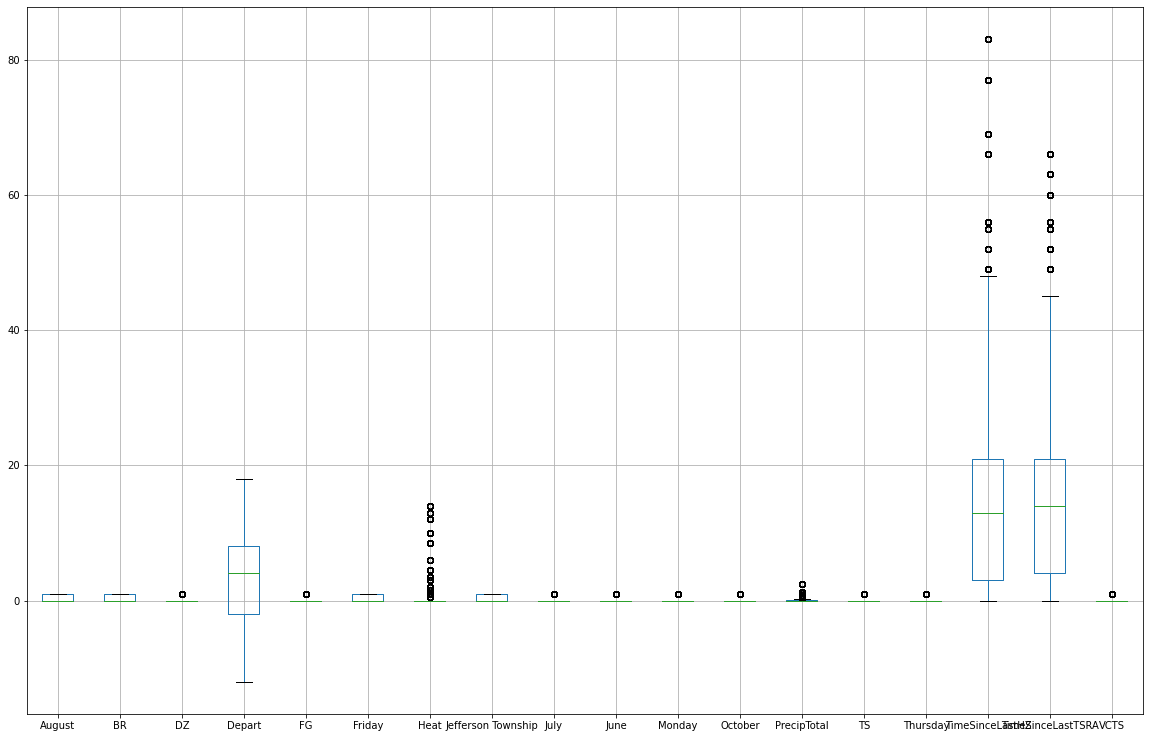

In [5]:
plt.figure(figsize=(20,13))
X_train.boxplot()

# Random Forest Model:

In [23]:
#First we need to scale our data before we fit our model.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test[X_train.columns])

In [24]:
X_test_scaled

array([[-0.75,  1.44, -0.16, ..., -0.53, -0.57, -0.22],
       [ 1.33, -0.69, -0.16, ...,  1.75,  1.18, -0.22],
       [-0.75, -0.69, -0.16, ...,  0.02, -0.79, -0.22],
       ...,
       [-0.75, -0.69, -0.16, ..., -0.36,  1.58, -0.22],
       [ 1.33, -0.69, -0.16, ...,  0.45, -0.57, -0.22],
       [ 1.33,  1.44, -0.16, ..., -0.64,  0.17,  4.6 ]])

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 42, n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

C:\Users\jhua\AppData\Local\Temp\ipykernel_16584\1937885308.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_res = clf.fit(X_train_scaled, y_train)


Random Forest: Accuracy=0.947
Random Forest: f1-score=0.922


In [25]:
cm

array([[2986,    0],
       [ 166,    0]], dtype=int64)

It looks like our random forest model just predicted "No Virus" for every single datapoint! This model will obviously run into problems when trying to generalize so let's try a different one.

# XG Boost Model: